In [218]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import subprocess

In [219]:
RAW_OFFLINE_DOCS_PATH = "/home/elissa/ADFA/ADFA-ODT/ProcessDocs/ProcessKotlinDocs/offline/html"
PROCESSED_OFFLINE_DOCS_PATH = "/home/elissa/ADFA/ADFA-ODT/ProcessDocs/ProcessKotlinDocs/out"

In [220]:
def get_dir_size(dirname):
    f = subprocess.run(["du", "-sh", "-b", dirname], capture_output=True, text=True)
    total_size = f.stdout.split("\t")[0]
    print("Total size of webhelp docs " + str(total_size) + " bytes")

In [221]:
def get_file_info(file_path):
    # Get file extension, if any
    basename = os.path.basename(file_path)
    if "." in basename:
        extension = basename.split(".")[-1]
    else:
        extension = None

    # File size
    size = os.path.getsize(file_path)
    
    return size, extension

In [222]:
def filetype_analysis(root_path):
    # Enumerate all files
    cur_dir = root_path
    dir_list = [cur_dir]
    files_list = []
    
    while len(dir_list) > 0:
        cur_dir = dir_list.pop()
        files = [os.path.join(cur_dir, f) for f in os.listdir(cur_dir) if os.path.isfile(os.path.join(cur_dir, f))]
        dirs = [os.path.join(cur_dir, d) for d in os.listdir(cur_dir) if os.path.isdir(os.path.join(cur_dir, d))]
        
        dir_list.extend(dirs)
        files_list.extend(files)

    # Create a table with file names, sizes, and extensions
    file_data = [[file, *get_file_info(file)] for file in files_list]
    num_files = len(files_list)

    file_df = pd.DataFrame(file_data, columns=['file_name', 'file_size', 'file_extension'])

    all_file_extensions = file_df.file_extension.unique()

    sizes_by_ext_raw = []

    for file_ext in all_file_extensions:
        if file_ext == None:
            temp_df = file_df[file_df['file_extension'].isnull()]
        else:
            temp_df = file_df[file_df['file_extension'] == file_ext]
    
        n_files =  int(len(temp_df.file_size.values))
        min_file_size = int(min(temp_df.file_size.values))
        max_file_size = int(max(temp_df.file_size.values))
        mean_file_size = int(np.floor(np.mean(temp_df.file_size.values)))
        total_size = int(np.sum(temp_df.file_size.values))
        file_names = [f.replace(root_path, "") for f in list(temp_df["file_name"].unique())]
    
        sizes_by_ext_raw += [[str(file_ext), n_files, min_file_size, mean_file_size, max_file_size, total_size, file_names]]
    
    sizes_by_extension_df = pd.DataFrame(sizes_by_ext_raw, columns=['file_extension', 'num_files', 'min_file_size', 'mean_file_size', 'max_file_size', 'total_size', 'file_names'])

    return sizes_by_extension_df

In [223]:
def pie_chart(col1, col2, df, min_val):
    labels = []
    other_labels = []
    values = []
    misc_other_vals = []
    other_total = 0
    
    uniq_col1 = df[col1]
    for val in uniq_col1:
        col2_val = int(df[df[col1] == val][col2].values[0])
        if col2_val < min_val:
            misc_other_vals += [val]
            other_total += col2_val
            continue
        labels += [val]
        values += [col2_val]

    labels += ["OTHER"]
    values += [other_total]

    val_labels = []
    for x in range(len(labels)):
        val_labels += [[labels[x], values[x]]]
    pie_value_labels_srted = sorted(val_labels, key=lambda x:x[0])
    
    labels_pie = [a[0] for a in pie_value_labels_srted]
    vals_pie = [a[1] for a in pie_value_labels_srted]

    return labels_pie, vals_pie, misc_other_vals

# Kotlin raw docs

In [224]:
version = open(os.path.join(RAW_OFFLINE_DOCS_PATH, "..", "docs_version.txt")).read().strip()
print(version)

849a14e6a04f053444744fd43089dfe16172e3e1


In [225]:
df = filetype_analysis(RAW_OFFLINE_DOCS_PATH)
df

,file_extension,num_files,min_file_size,mean_file_size,max_file_size,total_size,file_names
0,html,346,256,23046,160682,7974138,"[/ksp-multi-round.html, /jvm-records.html, /re..."
1,version,2,0,0,0,0,"[/current.help.version, /images/current.help.v..."
2,json,5,2,14246,62023,71231,"[/config.json, /HelpTOC.json, /api-object-dige..."
3,xml,1,45021,45021,45021,45021,[/sitemap.xml]
4,png,214,1173,179238,1225913,38356972,"[/writerside_32.png, /writerside_64.png, /imag..."
5,jhm,1,99300,99300,99300,99300,[/Map.jhm]
6,js,25,0,101680,1935999,2542017,"[/frontend/pt-BR-translation.js, /frontend/676..."
7,txt,4,728,6061,13447,24244,"[/frontend/710.js.LICENSE.txt, /frontend/LICEN..."
8,ttf,18,197104,200378,203940,3606812,"[/frontend/Montserrat-LightItalic.ttf, /fronte..."
9,css,4,1460,240515,708991,962060,"[/frontend/preview.css, /frontend/213f62978ec2..."


In [226]:
labels, values, misc_other_vals = pie_chart("file_extension", "total_size", df, 200000)
s_t = np.sum(df["total_size"])

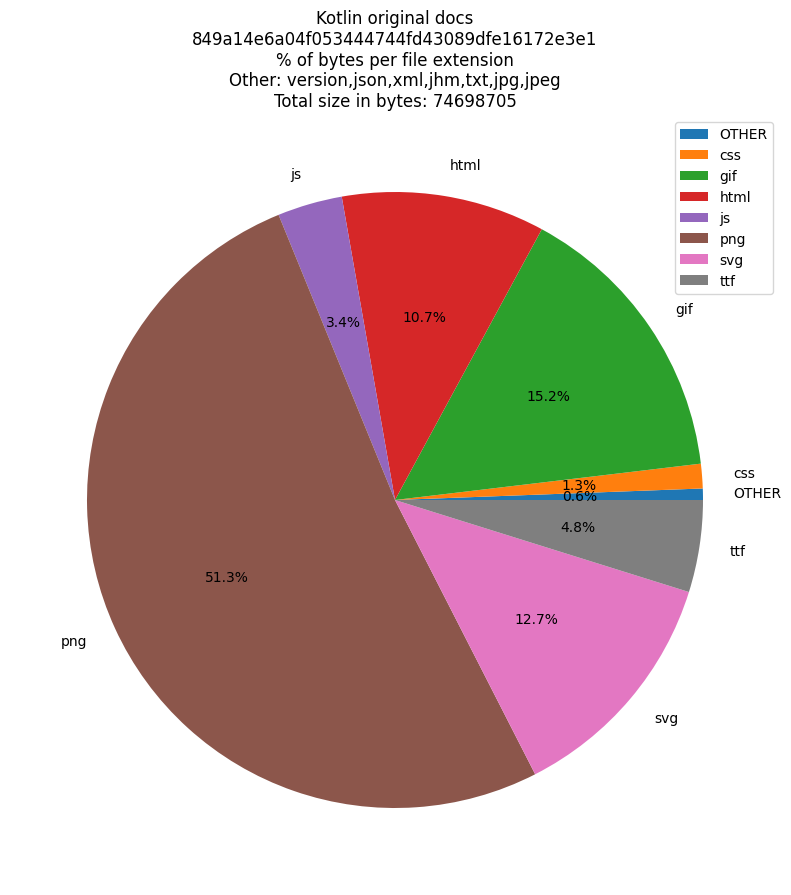

In [227]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
x = ax.pie(values, labels=labels, autopct='%1.1f%%')
plt.legend(labels, loc="best")
plt.title("Kotlin original docs\n"+version+"\n% of bytes per file extension\nOther: " + ",".join(misc_other_vals) + "\nTotal size in bytes: " + str(s_t))
plt.savefig("kotlin_orig_total_size.png", bbox_inches='tight')

In [228]:
labels, values, misc_other_vals = pie_chart("file_extension", "num_files", df, 10)

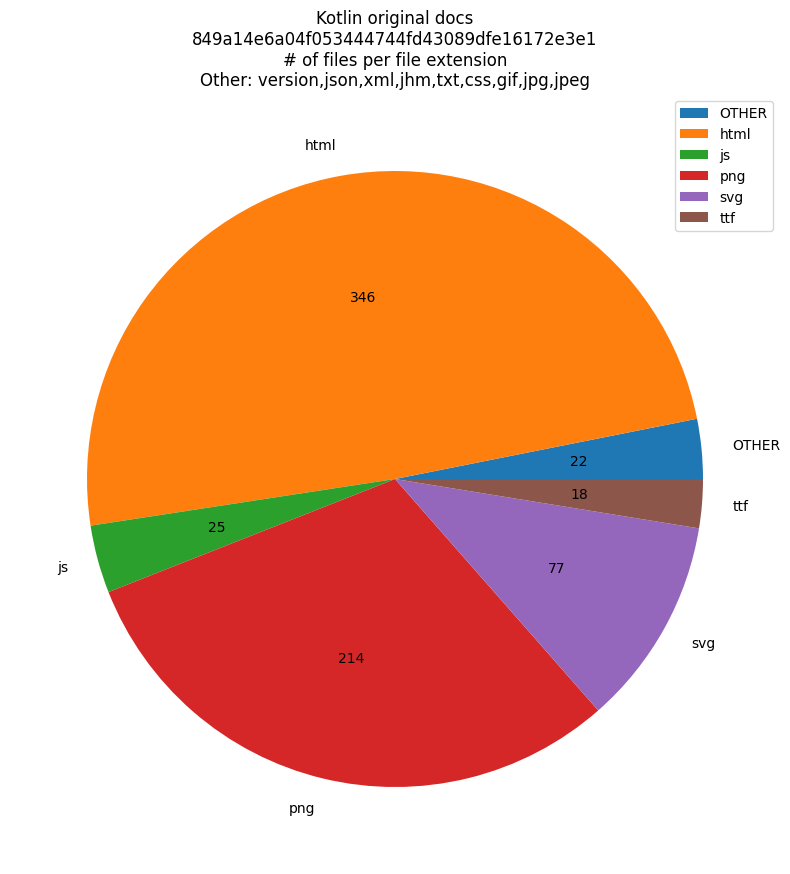

In [229]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
x = ax.pie(values, labels=labels, autopct=lambda x:int(x/100*sum(values)))
plt.legend(labels, loc="best")
plt.title("Kotlin original docs\n"+version+"\n# of files per file extension\nOther: " + ",".join(misc_other_vals))
plt.savefig("kotlin_orig_counts.png", bbox_inches='tight')

# Kotlin processed docs

In [230]:
version = open(os.path.join(PROCESSED_OFFLINE_DOCS_PATH, "docs_version.txt")).read().strip()
print(version)

849a14e6a04f053444744fd43089dfe16172e3e1


In [231]:
proc_df = filetype_analysis(PROCESSED_OFFLINE_DOCS_PATH)
proc_df

,file_extension,num_files,min_file_size,mean_file_size,max_file_size,total_size,file_names
0,html,346,298,12283,110086,4250224,"[/ksp-multi-round.html, /jvm-records.html, /re..."
1,js,1,2693,2693,2693,2693,[/toc_script.js]
2,css,2,664,854,1044,1708,"[/stlyle.css, /toc_style.css]"
3,png,214,1173,179238,1225913,38356972,"[/writerside_32.png, /writerside_64.png, /imag..."
4,txt,1,41,41,41,41,[/docs_version.txt]
5,svg,77,266,122739,2122910,9450977,"[/images/full-template-hierarchy.svg, /images/..."
6,gif,2,1154212,5680174,10206137,11360349,"[/images/data-analysis-notebook.gif, /images/m..."
7,version,1,0,0,0,0,[/images/current.help.version]
8,jpg,2,19288,90443,161598,180886,"[/images/ios-hierarchy-example.jpg, /images/bi..."
9,jpeg,1,24698,24698,24698,24698,[/images/head-first-kotlin.jpeg]


In [232]:
labels, values, misc_other_vals = pie_chart("file_extension", "total_size", proc_df, 200000)
s_t = np.sum(proc_df["total_size"])

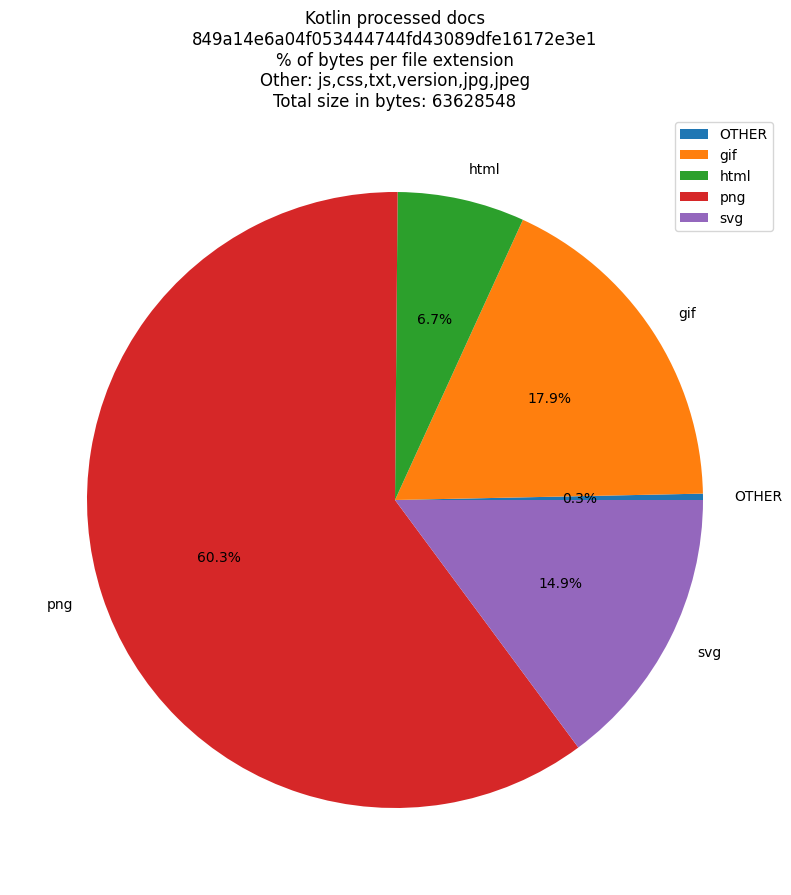

In [233]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
x = ax.pie(values, labels=labels, autopct='%1.1f%%')
plt.legend(labels, loc="best")
plt.title("Kotlin processed docs\n"+version+"\n% of bytes per file extension\nOther: " + ",".join(misc_other_vals) + "\nTotal size in bytes: " + str(s_t))
plt.savefig("kotlin_proc_total_size.png", bbox_inches='tight')

In [234]:
labels, values, misc_other_vals = pie_chart("file_extension", "num_files", proc_df, 10)

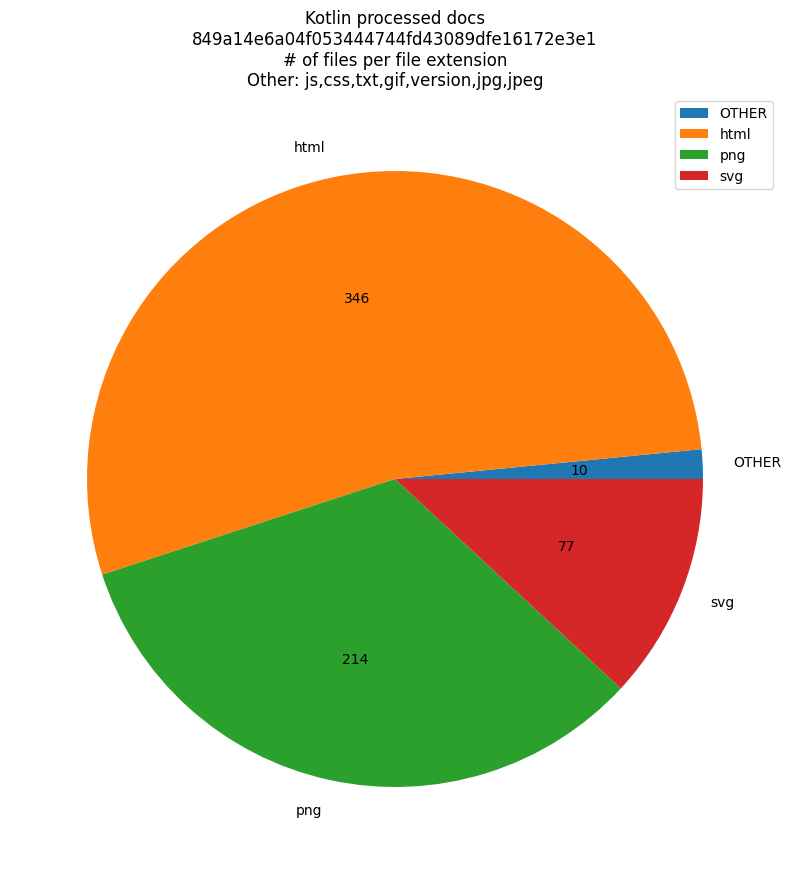

In [235]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
x = ax.pie(values, labels=labels, autopct=lambda x:round(x/100*sum(values)))
plt.legend(labels, loc="best")
plt.title("Kotlin processed docs\n"+version+"\n# of files per file extension\nOther: " + ",".join(misc_other_vals))
plt.savefig("kotlin_proc_counts.png", bbox_inches='tight')

# File count discrepancy analysis

In [236]:
KOTLIN_ORIG_PNGS = set(list(df[df["file_extension"] == "png"]["file_names"])[0])
KOTLIN_PROC_PNGS = set(list(proc_df[proc_df["file_extension"] == "png"]["file_names"])[0])
KOTLIN_ORIG_HTML = set(list(df[df["file_extension"] == "html"]["file_names"])[0])
KOTLIN_PROC_HTML = set(list(proc_df[proc_df["file_extension"] == "html"]["file_names"])[0])

In [237]:
KOTLIN_ORIG_PNGS.difference(KOTLIN_PROC_PNGS)

set()

In [238]:
check32 = subprocess.run(["grep", "-ir", "writerside_32", PROCESSED_OFFLINE_DOCS_PATH], capture_output=True, text=True)
check64 = subprocess.run(["grep", "-ir", "writerside_64", PROCESSED_OFFLINE_DOCS_PATH], capture_output=True, text=True)

In [239]:
check32.stdout

'/home/elissa/ADFA/ADFA-ODT/ProcessDocs/ProcessKotlinDocs/out/home.html:<html lang="en-US" data-preset="contrast" data-primary-color="#307FFF"><head><meta http-equiv="Content-Type" content="text/html; charset=UTF-8"><meta charset="UTF-8"><meta name="robots" content="noindex"><meta name="built-on" content="2025-04-22T12:04:16.050038331"><title>Kotlin Docs | Kotlin</title><script type="application/json" id="virtual-toc-data">[]</script><script type="application/json" id="topic-shortcuts"></script><link href="frontend/app.css" rel="stylesheet"><meta name="msapplication-TileColor" content="#000000"><link rel="icon" type="image/png" sizes="32x32" href="writerside_32.png"><link rel="icon" type="image/png" sizes="64x64" href="writerside_64.png"><meta name="image" content=""><!-- Open Graph --><meta property="og:title" content="Kotlin Docs | Kotlin"><meta property="og:description" content=""><meta property="og:image" content=""><meta property="og:site_name" content="Kotlin Help"><meta property

In [240]:
check64.stdout

'/home/elissa/ADFA/ADFA-ODT/ProcessDocs/ProcessKotlinDocs/out/home.html:<html lang="en-US" data-preset="contrast" data-primary-color="#307FFF"><head><meta http-equiv="Content-Type" content="text/html; charset=UTF-8"><meta charset="UTF-8"><meta name="robots" content="noindex"><meta name="built-on" content="2025-04-22T12:04:16.050038331"><title>Kotlin Docs | Kotlin</title><script type="application/json" id="virtual-toc-data">[]</script><script type="application/json" id="topic-shortcuts"></script><link href="frontend/app.css" rel="stylesheet"><meta name="msapplication-TileColor" content="#000000"><link rel="icon" type="image/png" sizes="32x32" href="writerside_32.png"><link rel="icon" type="image/png" sizes="64x64" href="writerside_64.png"><meta name="image" content=""><!-- Open Graph --><meta property="og:title" content="Kotlin Docs | Kotlin"><meta property="og:description" content=""><meta property="og:image" content=""><meta property="og:site_name" content="Kotlin Help"><meta property

The two missing pngs are Writerside artifacts that are not referenced in any location in the processed offline documentation.

In [241]:
html_diff = list(KOTLIN_ORIG_HTML.difference(KOTLIN_PROC_HTML))

In [242]:
html_diff

['/frontend/index.html']

In [168]:
redirects = []
not_redirects = []
size = 0
for f in html_diff:
    content = open(os.path.join(RAW_OFFLINE_DOCS_PATH, f[1:]), "r").read()
    size += len(content)
    if "You will be redirected" in content:
        redirects += [f]
    else:
        not_redirects += [f]

In [169]:
not_redirects

['/frontend/index.html', '/home.html', '/multiplatform.html']

In [170]:
size

24887

In [101]:
JAVA_DOCS_PATH = "/home/elissa/CoGoTooltips/external/javadocs"
KOTLIN_DOCS_PATH = "/home/elissa/IdeaProjects/kotlin/Writerside/docs/webhelpo"
KOTLIN_PROCESSED_DOCS_PATH = "/home/elissa/CoGoTooltips/external/kotlindocs"
WEBHELP_PATH = "/home/elissa/CoGoTooltips/html/cogohelp"
DEVSITE_PATH = "/home/elissa/ADFA/devsite_postprocess/outtest"

# WebHelp

In [399]:
f = subprocess.run(["du", "-sh", "-b", WEBHELP_PATH], capture_output=True, text=True)
total_size = f.stdout.split("\t")[0]
print("Total size of webhelp docs " + str(total_size) + " bytes")

Total size of webhelp docs 22227697 bytes


In [400]:
web_df = filetype_analysis(WEBHELP_PATH)
print(web_df)

  file_extension  num_files  min_file_size  mean_file_size  max_file_size  \
0            png         53            274           47178         361905   
1           html         52           3800           21513         120060   
2             js         10           1494           30743         105766   
3            svg          1           1468            1468           1468   
4            css          2           1949            4186           6424   
5            gif          5             56            1903           7657   
6            pdf          3        1097854         6093913        9797404   

   total_size  
0     2500470  
1     1118698  
2      307432  
3        1468  
4        8373  
5        9517  
6    18281739  


In [401]:
sorted_web_raw = web_df[["file_extension", "num_files", "total_size"]].sort_values("total_size", ascending=False)
sorted_web_raw.to_csv("web_raw_breakdown.tsv", sep="\t", index=False)

In [403]:
labels, values, misc_other_vals = pie_chart("file_extension", "total_size", web_df, 100000)

In [412]:
s_t = np.sum(web_df["total_size"])
print(s_t)
print(np.sum(web_df["num_files"]))

22227697
126


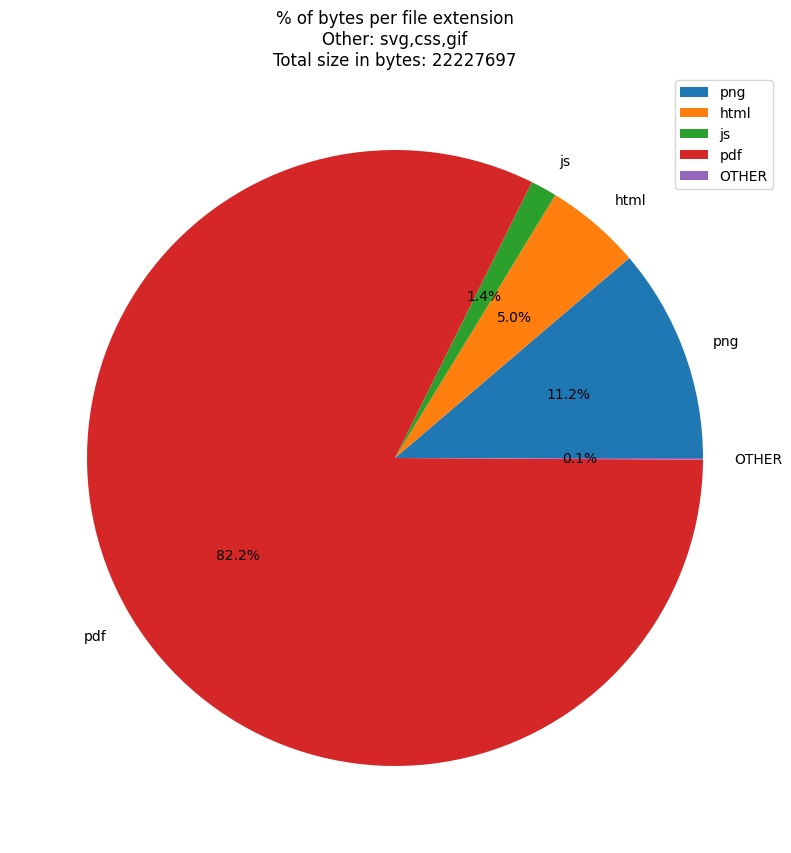

In [408]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
x = ax.pie(values, labels=labels, autopct='%1.1f%%')
plt.legend(labels, loc="best")
plt.title("% of bytes per file extension\nOther: " + ",".join(misc_other_vals) + "\nTotal size in bytes: " + str(s_t))
plt.savefig("web_raw_total_size.png", bbox_inches='tight')

In [409]:
labels, values, misc_other_vals = pie_chart("file_extension", "num_files", web_df, 10)

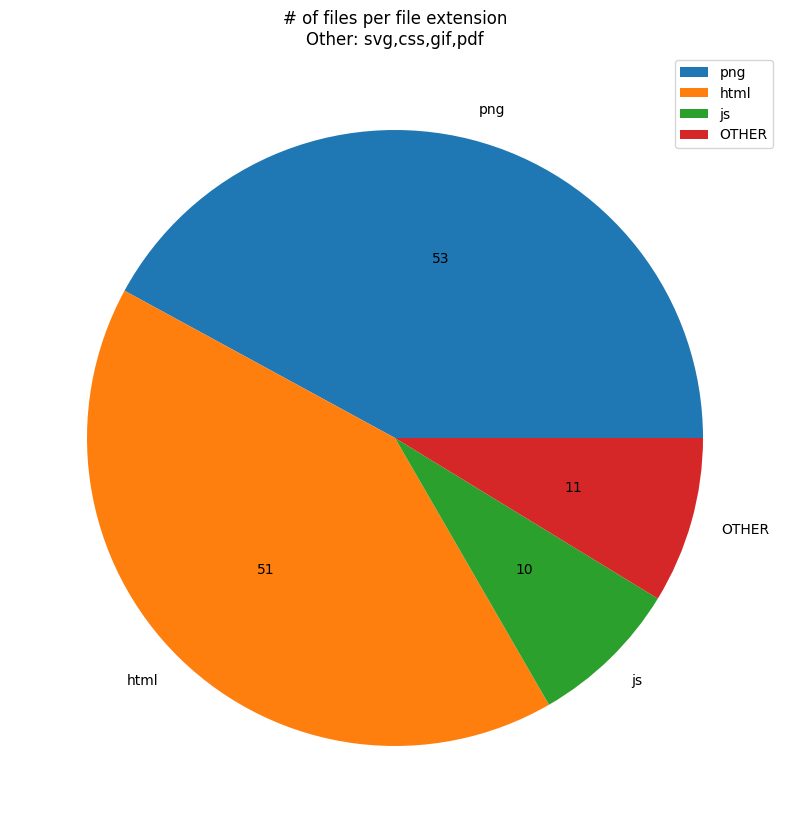

In [411]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
x = ax.pie(values, labels=labels, autopct=lambda x:int(x/100*sum(values)))
plt.legend(labels, loc="best")
plt.title("# of files per file extension\nOther: " + ",".join(misc_other_vals))
plt.savefig("web_raw_counts.png", bbox_inches='tight')

## Java docs

In [345]:
f = subprocess.run(["du", "-sh", "-b", JAVA_DOCS_PATH], capture_output=True, text=True)
total_size = f.stdout.split("\t")[0]
print("Total size of raw Java API docs " + str(total_size) + " bytes")

Total size of raw Java API docs 278706486 bytes


In [346]:
java_df = filetype_analysis(JAVA_DOCS_PATH)
print(java_df)

   file_extension  num_files  min_file_size  mean_file_size  max_file_size  \
0            html      10140            115           26625        5972084   
1            None          3            440           52592         151805   
2    alternatives          1           1119            1119           1119   
3          Debian          1           2438            2438           2438   
4              gz          9           1442          269199        2162131   
5             css          4           1498           13926          32075   
6              js          9           1364          619157        4870424   
7             svg         60            780            2188          22087   
8             png          9            394            9435          25468   
9             gif         61            290            3703          12309   
10            jpg          2          26097           33288          40479   
11            log          1           2766            2766     

In [392]:
sorted_java_raw = java_df[["file_extension", "num_files", "total_size"]].sort_values("total_size", ascending=False)
sorted_java_raw.to_csv("java_raw_breakdown.tsv", sep="\t", index=False)

In [393]:
labels, values, misc_other_vals = pie_chart("file_extension", "total_size", java_df, 250000)

In [394]:
j_t = np.sum(java_df["total_size"])

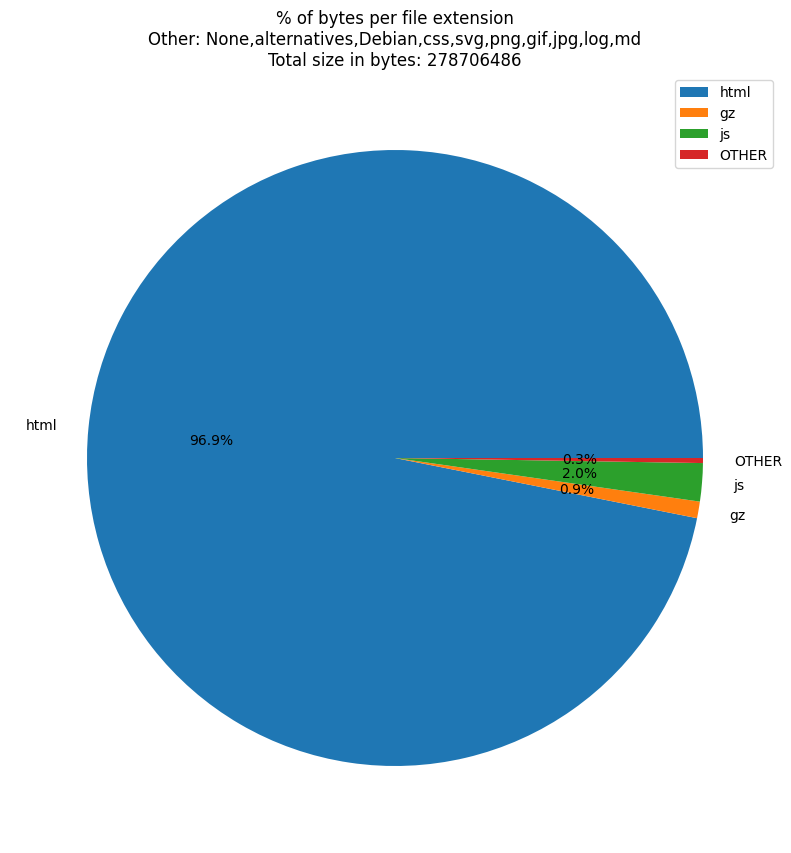

In [395]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
x = ax.pie(values, labels=labels, autopct='%1.1f%%')
plt.legend(labels, loc="best")
plt.title("% of bytes per file extension\nOther: " + ",".join(misc_other_vals) + "\nTotal size in bytes: " + str(j_t))
plt.savefig("java_raw_total_size.png", bbox_inches='tight')

In [357]:
labels, values, misc_other_vals = pie_chart("file_extension", "num_files", df, 10)

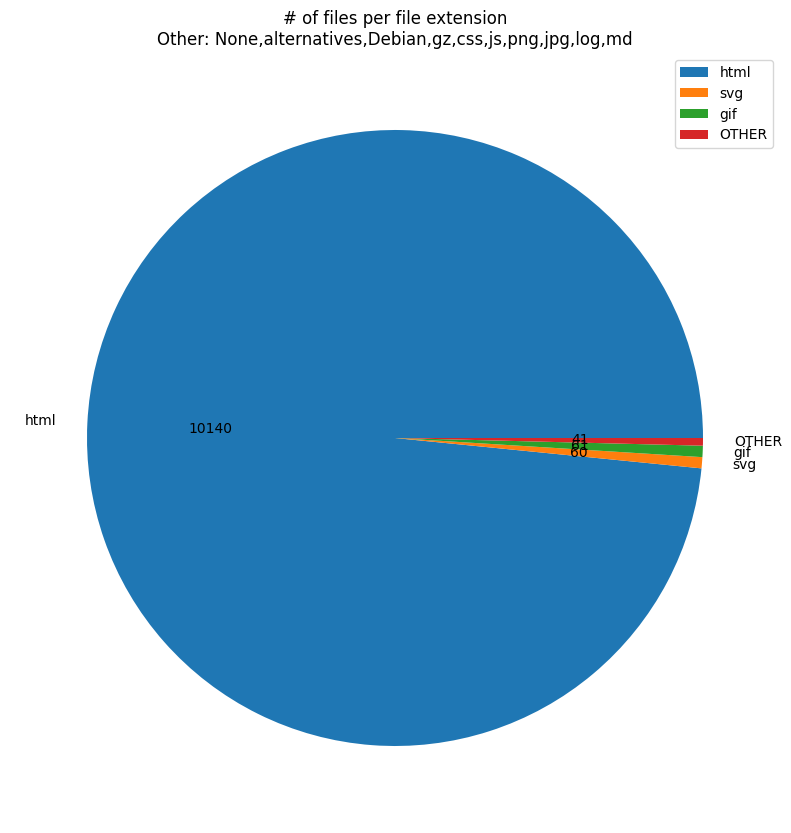

In [359]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
x = ax.pie(values, labels=labels, autopct=lambda x:int(x/100*sum(values)))
plt.legend(labels, loc="best")
plt.title("# of files per file extension\nOther: " + ",".join(misc_other_vals))
plt.savefig("java_raw_counts.png", bbox_inches='tight')

In [314]:
for l in range(len(labels)):
    print(str(labels[l]) + "\t" + str(values[l]))

html	10140
svg	60
gif	61
OTHER	41


## Kotlin raw docs

In [335]:
f = subprocess.run(["du", "-sh", "-b", KOTLIN_DOCS_PATH], capture_output=True, text=True)

In [336]:
total_size = f.stdout.split("\t")[0]
print("Total size of raw Kotlin docs " + str(total_size) + " bytes")

Total size of raw Kotlin docs 74710626 bytes


In [337]:
kotlin_raw_df = filetype_analysis(KOTLIN_DOCS_PATH)
print(kotlin_raw_df)

   file_extension  num_files  min_file_size  mean_file_size  max_file_size  \
0            html        346            256           22988         159929   
1         version          2              0               0              0   
2            json          5              2           14215          61871   
3             xml          1          45021           45021          45021   
4             png        216           1173          177886        1225913   
5             jhm          1          99370           99370          99370   
6              js         25              0          101030        1931871   
7             txt          4            728            6061          13447   
8             css          4           1460          239868         706403   
9             ttf         18         197104          200378         203940   
10            svg         76            266          124150        2122910   
11            gif          2        1154212         5680174     

In [377]:
k_r_total_size = np.sum(kotlin_raw_df["total_size"])

In [387]:
sorted_kotlin_raw = kotlin_raw_df[["file_extension", "num_files", "total_size"]].sort_values("total_size", ascending=False)
sorted_kotlin_raw.to_csv("kotlin_raw_breakdown.tsv", sep="\t", index=False)

In [388]:
labels, values, misc_other_vals = pie_chart("file_extension", "total_size", kotlin_raw_df, 200000)

In [389]:
labels

['html', 'png', 'js', 'css', 'ttf', 'svg', 'gif', 'OTHER']

In [390]:
values

[7954070, 38423457, 2525765, 959472, 3606812, 9435403, 11360349, 445298]

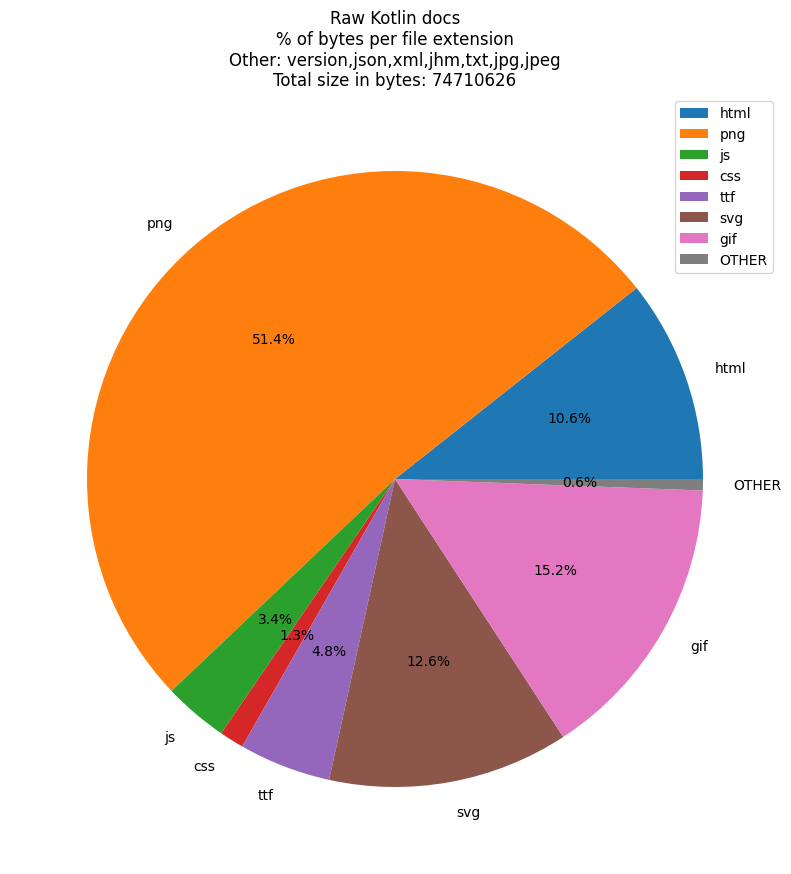

In [391]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
x = ax.pie(values, labels=labels, autopct='%1.1f%%')
plt.legend(labels, loc="best")
plt.title("Raw Kotlin docs\n% of bytes per file extension\nOther: " + ",".join(misc_other_vals) + "\nTotal size in bytes: " + str(k_r_total_size))
plt.savefig("kotlin_raw_total_size.png", bbox_inches='tight')

In [332]:
labels, values, misc_other_vals = pie_chart("file_extension", "num_files", kotlin_raw_df, 10)

In [333]:
sum(values)

703

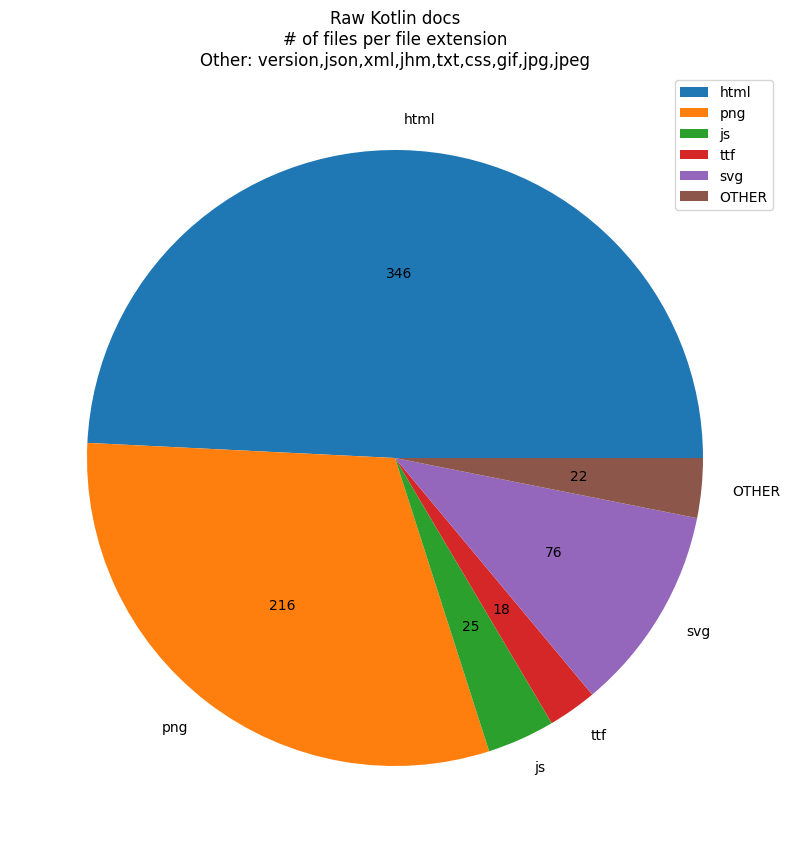

In [334]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
x = ax.pie(values, labels=labels, autopct=lambda x:int(x/100*sum(values)))
plt.legend(labels, loc="best")
plt.title("Raw Kotlin docs\n# of files per file extension\nOther: " + ",".join(misc_other_vals))
plt.savefig("kotlin_raw_counts.png", bbox_inches='tight')

# Kotlin processed docs

In [10]:
f = subprocess.run(["du", "-sh", "-b", KOTLIN_PROCESSED_DOCS_PATH], capture_output=True, text=True)
total_size = f.stdout.split("\t")[0]
print("Total size of processed Kotlin docs " + str(total_size) + " bytes")

Total size of processed Kotlin docs 66787340 bytes


In [11]:
kotlin_processed_df = filetype_analysis(KOTLIN_PROCESSED_DOCS_PATH)
print(kotlin_processed_df)

  file_extension  num_files  min_file_size  mean_file_size  max_file_size  \
0           html        283           1344           28244         168218   
1             js          1           2693            2693           2693   
2            css          2            694             965           1237   
3            svg         73            266          125615        2122910   
4            png        218           1173          174557        1225913   
5            gif          2        1154212         5680174       10206137   
6        version          1              0               0              0   
7            jpg          2          19288           90443         161598   
8           jpeg          1          24698           24698          24698   

   total_size  
0     7993307  
1        2693  
2        1931  
3     9169912  
4    38053564  
5    11360349  
6           0  
7      180886  
8       24698  


In [375]:

print(np.sum(kotlin_processed_df["num_files"]))
print(np.sum(kotlin_processed_df["total_size"]))
kot_processed_total = np.sum(kotlin_processed_df["total_size"])

583
66787340


In [362]:
sorted_kotlin_processed = kotlin_processed_df[["file_extension", "num_files", "total_size"]].sort_values("total_size", ascending=False)
sorted_kotlin_processed.to_csv("kotlin_processed_breakdown.tsv", sep="\t", index=False)

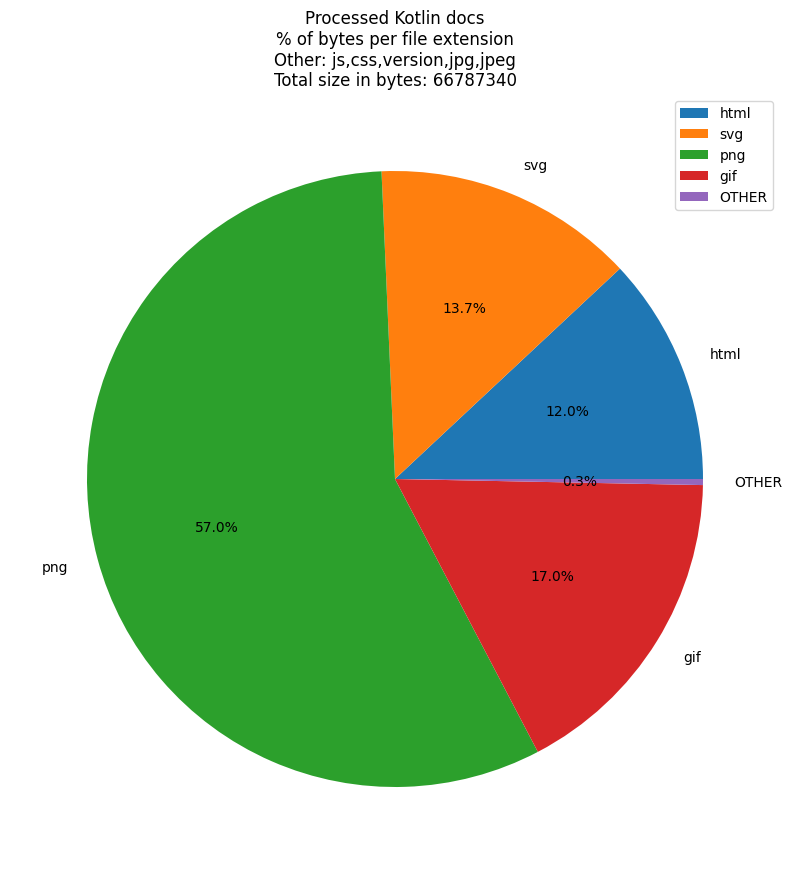

In [386]:
labels, values, misc_other_vals = pie_chart("file_extension", "total_size", kotlin_processed_df, 200000)
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
x = ax.pie(values, labels=labels, autopct='%1.1f%%')
plt.legend(labels, loc="best")
plt.title("Processed Kotlin docs\n% of bytes per file extension\nOther: " + ",".join(misc_other_vals) + "\nTotal size in bytes: " + str(kot_processed_total))
plt.savefig("kotlin_processed_total_size.png", bbox_inches='tight')

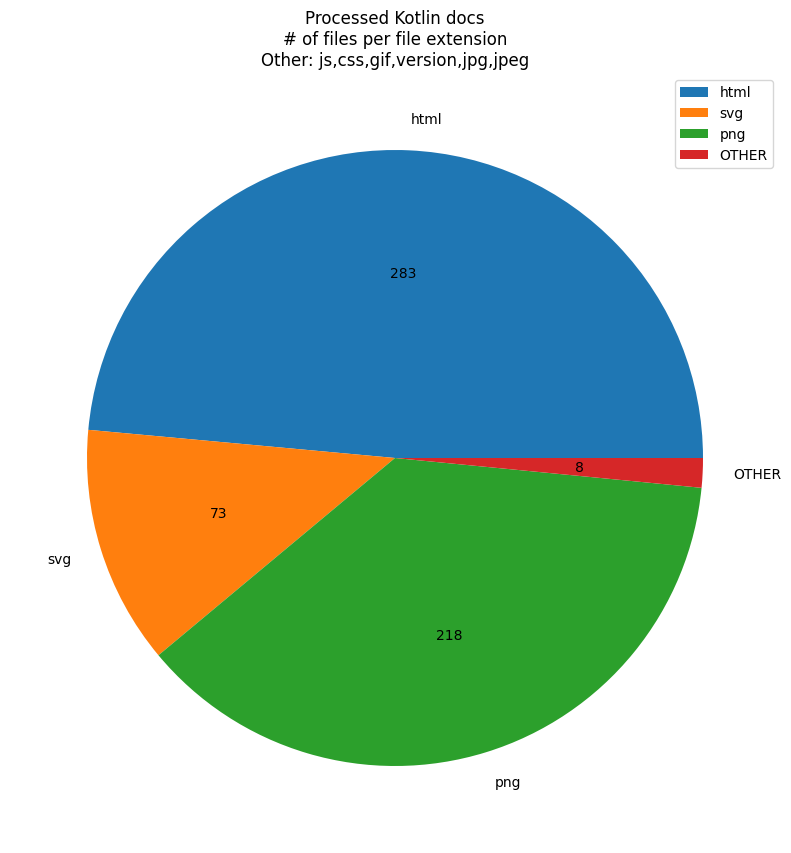

In [370]:
labels, values, misc_other_vals = pie_chart("file_extension", "num_files", kotlin_processed_df, 10)
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
x = ax.pie(values, labels=labels, autopct=lambda x:int(x/100*sum(values)))
plt.legend(labels, loc="best")
plt.title("Processed Kotlin docs\n# of files per file extension\nOther: " + ",".join(misc_other_vals))
plt.savefig("kotlin_processed_counts.png", bbox_inches='tight')

# Google developer site

In [6]:
f = subprocess.run(["du", "-sh", "-b", DEVSITE_PATH], capture_output=True, text=True)
total_size = f.stdout.split("\t")[0]
print("Total size of webhelp docs " + str(total_size) + " bytes")

Total size of webhelp docs 159530498 bytes


In [8]:
web_df = filetype_analysis(DEVSITE_PATH)
print(web_df)

  file_extension  num_files  min_file_size  mean_file_size  max_file_size  \
0           html        228           1323           17121         109017   
1            css          1            457             457            457   
2            png        377            136          109015        1214616   
3            mp4         60          14975         1199469       19711861   
4            svg         21            342          406516        6234755   
5            gif         28           2598         1028706        9428843   
6            ogv          7          50321          274584         727629   
7           webm          9          18739           95797         394092   
8            mov          4         121946          608638        1357576   

   total_size  
0     3903594  
1         457  
2    41098841  
3    71968165  
4     8536847  
5    28803778  
6     1922088  
7      862175  
8     2434553  


In [21]:
sorted_dev_processed = web_df[["file_extension", "num_files", "total_size"]].sort_values("total_size", ascending=False)
sorted_dev_processed.to_csv("dev_processed_breakdown.tsv", sep="\t", index=False)

In [9]:
s_t = np.sum(web_df["total_size"])
print(s_t)
print(np.sum(web_df["num_files"]))

159530498
735


In [18]:
labels, values, misc_other_vals = pie_chart("file_extension", "total_size", web_df, 2000000)

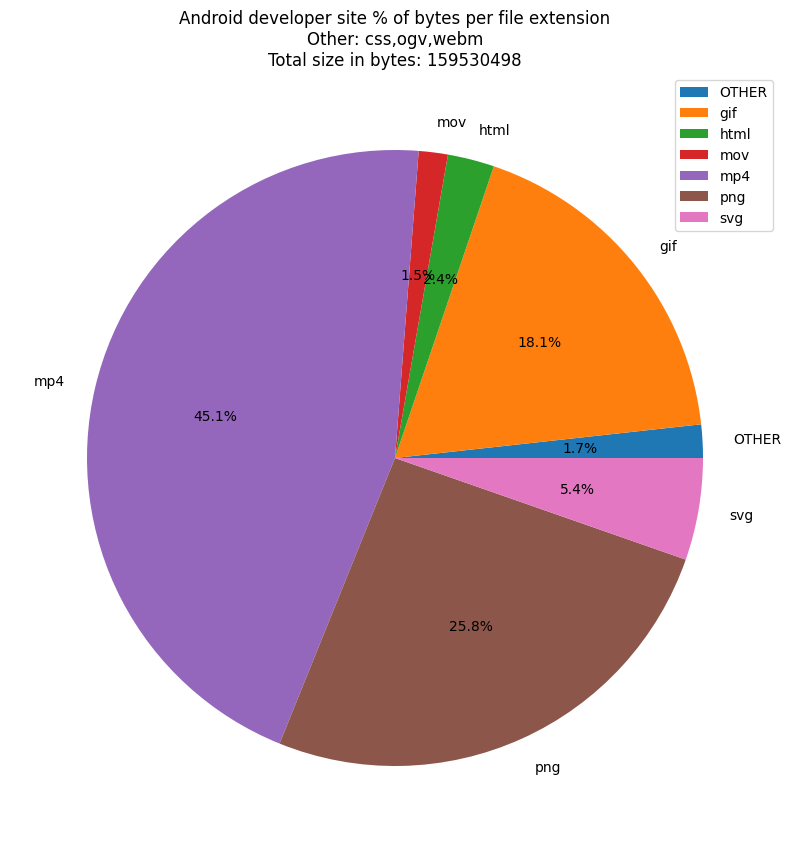

In [19]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
x = ax.pie(values, labels=labels, autopct='%1.1f%%')
plt.legend(labels, loc="best")
plt.title("Android developer site % of bytes per file extension\nOther: " + ",".join(misc_other_vals) + "\nTotal size in bytes: " + str(s_t))
plt.savefig("dev_total_size.png", bbox_inches='tight')

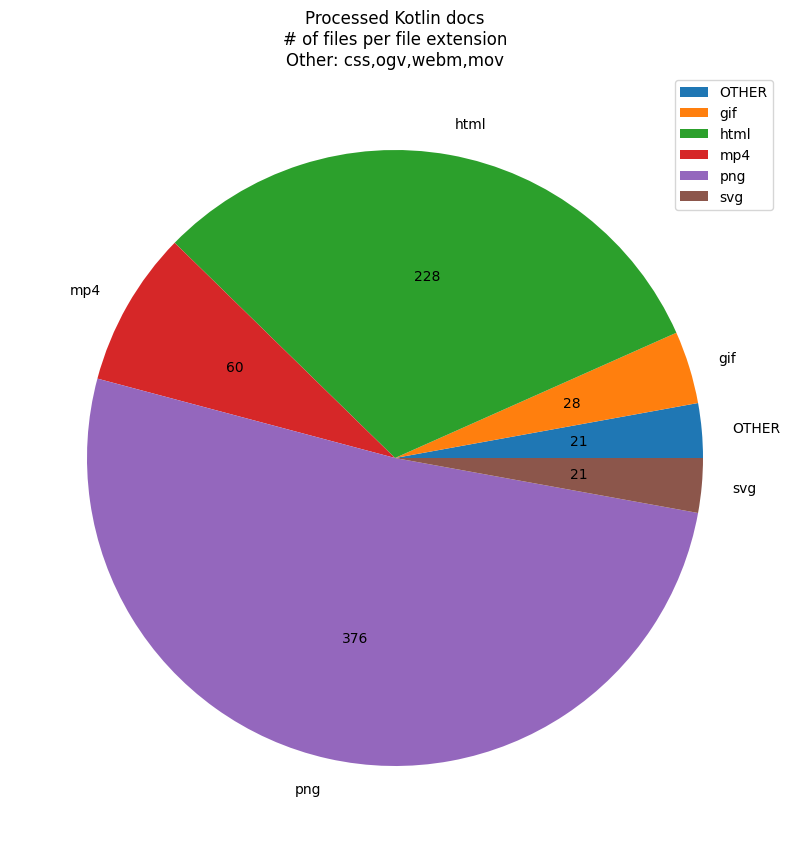

In [20]:
labels, values, misc_other_vals = pie_chart("file_extension", "num_files", web_df, 10)
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
x = ax.pie(values, labels=labels, autopct=lambda x:int(x/100*sum(values)))
plt.legend(labels, loc="best")
plt.title("Processed Kotlin docs\n# of files per file extension\nOther: " + ",".join(misc_other_vals))
plt.savefig("dev_processed_counts.png", bbox_inches='tight')